In [1]:
import torch
from torch import Tensor
from torch.nn import Linear
from torch.nn import ReLU
from torch.nn import Tanh
from torch.nn import Sigmoid
from torch.nn import Module
from torch.nn import Embedding 
from torch.optim import SGD,Adam
from torch.nn import CrossEntropyLoss, BCELoss, MSELoss
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score, mean_squared_error
import numpy as np
from numpy import vstack
from torch.utils.data import random_split
from torch.nn.init import kaiming_uniform_
from torch.nn.init import xavier_uniform_
import matplotlib
matplotlib.rcParams['pdf.fonttype'] = 42
matplotlib.rcParams['ps.fonttype'] = 42

In [2]:
# model definition
class RNN(Module):
    # define model elements
    # n_inputs: input dimension
    # n_hidden: number of neurons per layer
    # n_layers: number of hidden layers
    def __init__(self, n_hidden, n_layers, input_dim, embedding_dim):
        super(RNN, self).__init__()
        
        # hidden layers
        #self.embed = Embedding(input_dim, embedding_dim) 
        self.hidden = {}
        self.act = {}
        for i in range(n_layers):
            if i==0:
                n_in = input_dim + n_hidden # embedding_dim + n_hidden
            else:
                n_in = n_hidden * 2
            # input to hidden layer
            self.hidden[i] = Linear(n_in, n_hidden)
            kaiming_uniform_(self.hidden[i].weight, nonlinearity='relu')
            # non-linearity
            self.act[i] = Tanh() # or ReLu
        
        # output
        self.out = Linear(n_hidden,input_dim) # dimension of output is 2
        xavier_uniform_(self.out.weight)
        #self.actout = Sigmoid()
        
        
    # forward propagate input
    def forward(self, X, hidden_layer):
        n_layers = len(hidden_layer)
        #idx = torch.argmax(X,-1)
        #embedding = self.embed(idx)
        for i in range(n_layers):
            if i == 0:
                # combine input with previous hidden
                combined = torch.cat((X, hidden_layer[i]), 1)
            else:
                # combine previous hidden with hidden
                combined = torch.cat((hidden_layer[i-1], hidden_layer[i]), 1)
            # input to hidden layer
            hidden_layer[i] = self.hidden[i](combined)
            hidden_layer[i] = self.act[i](hidden_layer[i])
            
        ## output
        output = self.out(hidden_layer[i])
        #output = self.actout(output)

        return output,hidden_layer

In [79]:
# train the model
def train_model(train_x,train_y, model):
    n_layers = len(model.hidden)
    n_hidden = model.hidden[0].weight.size()[0]
    # define the optimization
    criterion = MSELoss()
    optimizer = Adam(model.parameters(), lr=0.05)
    
    # enumerate epochs
    batch_size = train_x[0].size()[0]
    all_loss = []
    lossdiff = -1
    epoch = 0
    while lossdiff<0:
        # enumerate batches (xx and xY batch)    
        for xi,yi in zip(train_x,train_y):
            # clear the gradients
            optimizer.zero_grad()
            # initialise hidden states
            hi = {}
            for k in range(n_layers):
                hi[k] = torch.zeros((batch_size,n_hidden))
            #loss = 0
            for j in range(xi.size()[1]):
                xij = xi[:,j,:]

                # compute the model output
                yhat,hi = model(xij,hi)
                
                for k in range(n_layers):
                    hi[k] = hi[k].detach()
            # calculate loss on last prediction
            loss = criterion(yhat, yi)
            loss.backward(retain_graph=True)
            
            # update model weights
            optimizer.step()
        
        all_loss.append(loss.item())  
        if epoch>5:
            lossdiff = all_loss[-1]-np.mean(all_loss[-5:-1] )
        epoch +=1
    return all_loss

# evaluate the model
def evaluate_model(test_x,test_y, model):
    
    # this function returns the average accuracy on all input test sequences. One value per sequence
    # For now, it skips the first  items
    
    
    n_layers = len(model.hidden)
    n_hidden = model.hidden[0].weight.size()[0]

    batch_size = test_x[0].size()[0]
    num_seq = len(test_x)
    acc = []
    rand_acc = []
    for xi,yi in zip(test_x,test_y):
        
        # initialize hidden state
        hi = {}
        for k in range(n_layers):
            hi[k] = torch.zeros((batch_size,n_hidden))

        for j in range(xi.size()[1]):
            xij = xi[:,j,:]
            # compute the model output
            yhat,hi = model(xij,hi)
            
        # round to class values: this is if output is classification
        #yhat = np.argmax(yhat.detach().numpy(),-1)
        # store
        #acc.append(accuracy_score(yhat.detach().numpy(),yi))
        
        
        # if regression:
        yhat = yhat.detach().numpy()
        acc.append(np.mean((yhat-yi.numpy())**2))

    return acc 

def predict(x,model):
    
    n_layers = len(model.hidden)
    n_hidden = model.hidden[0].weight.size()[0]

    batch_size = x[0].size()[0]
    y = []
    h = []
    c = []
    for xi in x:
        hi = {}
        for k in range(n_layers):
            hi[k] = torch.zeros((batch_size,n_hidden))
        
        for j in range(xi.size()[1]):
            xij = xi[:,j,:]
            # compute the model output
            yhat,hi = model(xij,hi)
            
        yhat = yhat.detach().numpy() # predicted stimulus
        #ci = np.round(yhat) != xij.detach().numpy()
        ##print(np.sum(ci,1))
        #ci =  ((np.sum(ci,1)==0)==False).astype(int) # predicted sameness 1=change, 0=same
        y.append(yhat)
        #c.append(ci)
        h.append(hi)
        
    return y,h #,c


Create input sequences

In [305]:
def unique_pairs(dictionary):
    '''
    create matrix with unique pairs of (one-hot) vectors in dictionary
    
    dictionary: N x dimensionality; matrix of N (one-hot) vectors
    '''
    vecpairs = []
    for i in range(dictionary.shape[0]):
        for j in range(dictionary.shape[0]):
            if i!=j:
                vecpairs.append(np.vstack((dictionary[j,],dictionary[i,])))
    vecpairs = np.array(vecpairs) 
    return vecpairs

def unique_pairs_sequence(seq,repeats,pairs):
    
    '''
    Create a structured sequence such as 010101, replacing 0 and 1 with (one-hot) vectors from dictionary
    
    batch_size: number of sequence samples with different value for 0 and 1
    seq: list of sequence structures
    repeats: repeats per sequence chunk (e.g. 4 = 4xsize of sequence chunk)
    dictionary: matrix of (one-hot) vectors, shape: dic size X input size
    '''
    nseq = len(seq)
    x = np.zeros((nseq))
    input_size = pairs.shape[2]
    batch_size = pairs.shape[0]
    all_seq = []
    seq_len = []
    for s in seq:
        
        # pick value from dictionary:
        a = []
        b = []
        for i in range(batch_size):
            a.append(pairs[i,1,:]) # X
            b.append(pairs[i,0,:]) # Y
        a = np.array(a)
        b = np.array(b)
        # create sequence
        sequence = []
        for i,element in enumerate(s):
            if element==0:
                sequence.append(a)
            elif element==1:
                sequence.append(b)
        sequence = np.array(sequence)
         
        sequence = np.swapaxes(sequence,0,1)
        # add zero state
        #sequence = np.concatenate((sequence,np.zeros((batch_size,1,input_size))),1)
        out_sequence = sequence
        for r in range(repeats-1):
            # stack the sequence repeat times
            out_sequence = np.concatenate((out_sequence,sequence),1)
        all_seq.append(out_sequence)

    return all_seq


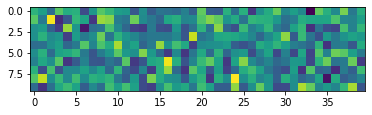

200 units per layer, 1 layer
For sequence [0, 0], MSE is 0.09360827229296168
For sequence [0, 1], MSE is 0.16768263851602871
For sequence [0, 0, 0, 1], MSE is 0.23406837201780742
For sequence [0, 0, 1, 1], MSE is 0.18326269139846166


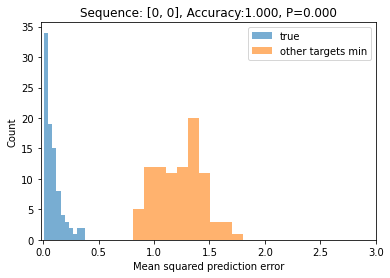

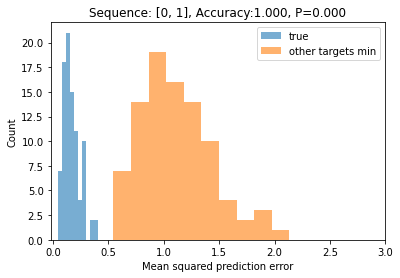

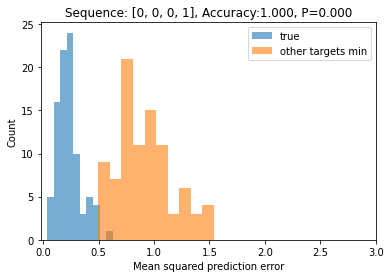

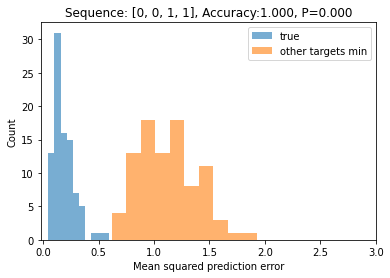

In [306]:
seq = [[0,0,0,0],[0,0,0,1],[0,1,0,1],[0,0,1,1]] # sequence structures to be used
seq_test = [[0,0],[0,1],[0,0,0,1],[0,0,1,1]]
Nseq = len(seq_test)
repeats = 10 # repeats per chunk in each sequence
input_dim = [40] # dimensionality of the input
dict_size = 10 # size of stimulus dictionary, can be input_size at max
hidden = [200]
layers = [1]

#embedding_dim = 100

# create matrix of stimulus
#a = np.ones(input_size)
#dictionary = np.diag(a)[:dict_size,:]




ntrials = dict_size*dict_size - dict_size
Ratio = np.zeros((len(input_dim),len(hidden),len(layers),len(test_sequence),ntrials))
Acc = np.zeros((len(input_dim),len(hidden),len(layers),len(test_sequence),ntrials))
for si,input_size in enumerate(input_dim):
    # produce random stimuli:
    dictionary = np.random.randn(dict_size,input_size) # use same size as for the one-hot encoding
    
    plt.imshow(dictionary)
    plt.show()
    
    # get unique pairs of stimuli
    pairs = unique_pairs(dictionary)
    
    # create training and test data
    sequence = unique_pairs_sequence(seq,repeats,pairs)
    test_sequence = unique_pairs_sequence(seq_test,repeats,pairs)
    
    for hi,n_hidden in enumerate(hidden):
        for li,n_layers in enumerate(layers):
            print('%s units per layer, %s layer'%(n_hidden,n_layers))
            MSE = np.zeros((ntrials,len(test_sequence)))
            Yhat = np.zeros((ntrials,len(test_sequence),input_size)) # store prediction here
            Ytrue = np.zeros((ntrials,len(test_sequence),input_size)) # store ground truth
            for k in range(ntrials):
                trainind = np.delete(np.arange(ntrials),k)
                train_x = []
                test_x = []
                train_y = []
                test_y = []
                # create data from numpy arrrays
                for i in range(len(seq)):
                    train_x.append(torch.Tensor(sequence[i][trainind,:-1,:])) #!!-1 if no zero element after each chunk, otherwise -2
                    train_y.append(torch.Tensor(sequence[i][trainind,-1,:]))
                
                for i in range(Nseq):
                    test_x.append(torch.Tensor(test_sequence[i][k:k+1,:-1,:]))
                    test_y.append(torch.Tensor(test_sequence[i][k:k+1,-1,:]))
            
                # train network
                model = RNN(n_hidden,n_layers,input_size,embedding_dim)
                Loss = train_model(train_x,train_y, model)
                #plt.figure()
                #plt.plot(Loss)
                #plt.show()
                # evaluate
                mse = evaluate_model(test_x,test_y, model)
                y,_ = predict(test_x,model)
                
                for i in range(Nseq):
                    MSE[k,i] = mse[i]
                    Yhat[k,i,:] = y[i][0,:] # hard coded!, works only if output 1 sample
                    Ytrue[k,i,:] = test_sequence[i][k,-1,:] # !!-1 if no zero element after each chunk, otherwise -2
                    
                    
            for i in range(Nseq):        
                print("For sequence %s, MSE is %s"%(seq_test[i],np.mean(MSE[:,i])))
            
            Error = np.zeros((len(test_sequence),ntrials))
            Errordist = np.zeros((len(test_sequence),ntrials,dict_size-1))
            
            for i in range(len(test_sequence)):
                for k in range(ntrials):
                    yhat = Yhat[k,i,:]
                    y = Ytrue[k,i,:]
                    yrep = np.repeat(y[None,:],dict_size,0)
                    target_idx = np.argmin(np.mean(abs(yrep-dictionary),1))
                    Error[i,k] = np.mean((yhat - y)**2) # calculate mean squared error of predicted vector with ground truth
                    yrep = np.repeat(yhat[None,:],dict_size-1,0)
                    Errordist[i,k,:] = np.mean((yrep - np.delete(dictionary,target_idx,0))**2,1) # calculate mean squared error of predicted vector with ground truth
                    # calculate ratio of samples equally small or smaller than sample
                    Ratio[si,hi,li,i,k] = sum(Errordist[i,k,:]<=Error[i,k])/(dict_size-1)
                    Acc[si,hi,li,i,k] = Error[i,k]<np.min(Errordist[i,k,])
                    
                ax = plt.subplot(111)
                plt.hist(Error[i,],label='true',alpha=.6)
                plt.hist(np.min(Errordist[i,],-1),label='other targets min',alpha=.6)
                ax.set_title('Sequence: %s, Accuracy:%.3f, P=%.3f'%(seq_test[i],np.mean(Acc[si,hi,li,i,:]),np.mean(Ratio[si,hi,li,i,:])))
                ax.set_xlabel('Mean squared prediction error')
                ax.set_xlim(-0.02,3)
                plt.ylabel('Count')
                plt.legend()
                plt.savefig('NIP_error_seq_%s.png'%seq_test[i])
                plt.show()

### Visualize grid search result

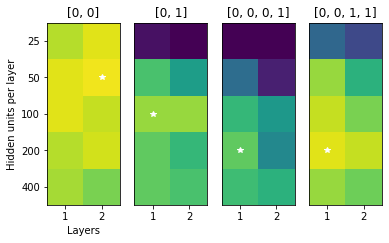

In [204]:
fig,ax = plt.subplots(1,len(test_sequence))
for i in range(Nseq):
    ax[i].imshow(np.mean(np.mean(Acc[:,:,i,],0),-1),vmin=.5,vmax=1)
    idxx = np.argmax(np.max(np.mean(np.mean(Acc[:,:,i,],0),-1),0))
    idxy = np.argmax(np.max(np.mean(np.mean(Acc[:,:,i,],0),-1),1))
    ax[i].plot(idxx,idxy,'*w')
    if i==0:
        ax[i].set_yticks(np.arange(len(hidden)))
        ax[i].set_yticklabels(hidden)
        ax[i].set_ylabel('Hidden units per layer')
    else:
        ax[i].set_yticks([])
    ax[i].set_xticks(np.arange(len(layers)))
    ax[i].set_xticklabels(layers)
    ax[i].set_title(seq_test[i])
ax[0].set_xlabel('Layers')
plt.savefig('NIP_grid_search_1.pdf')
plt.show()

Input size

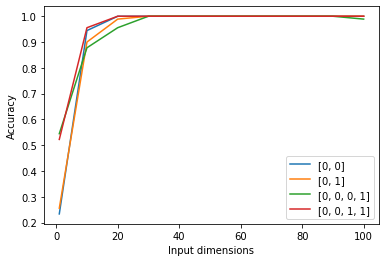

In [241]:
ax = plt.subplot(111)
for i in range(len(seq_test)):
    plt.errorbar(x=input_dim,y=np.mean(Acc[:,0,0,i,:],-1),label=seq_test[i])
#plt.xticks(np.arange(repeats),np.arange(repeats)+1)
ax.legend()
ax.set_xlabel('Input dimensions')
ax.set_ylabel('Accuracy')
plt.savefig('NIP_Accuracy_per_inputdim.pdf')
plt.show()

Number of chunks

In [288]:
dictionary2 = np.random.randn(30,input_size)


# get unique pairs of stimuli
pairs = unique_pairs(dictionary)

# create data
repeats = 20
Nrand = 100
sequence = unique_pairs_sequence(seq_test,repeats,pairs)
err = np.zeros((repeats,len(seq_test),pairs.shape[0]))
randerr = np.zeros((repeats,len(seq_test),pairs.shape[0],Nrand))
for k in range(repeats):
    x = []
    ytrue = []
    for i in range(len(seq_test)):
        chunk_length = len(seq_test[i])
        x.append(torch.Tensor(sequence[i][:,:(k+1)*chunk_length-1]))
        ytrue.append(sequence[i][:,(k+1)*chunk_length-1])
    y,_ = predict(x,model)
    for i in range(len(seq_test)):
        err[k,i,:] = np.mean((y[i]-ytrue[i])**2,-1)
        randerr[k,i,:] = np.mean((np.repeat(y[i][:,:,None],Nrand,2)-np.random.randn(pairs.shape[0],input_size,Nrand))**2,1)


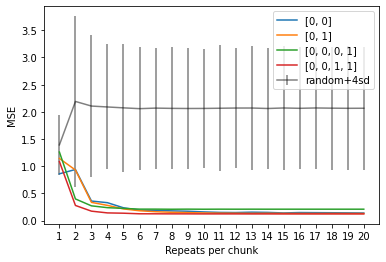

In [293]:
# plot
ax = plt.subplot(111)
for i in range(len(seq_test)):
    plt.errorbar(x=np.arange(repeats),y=np.mean(err[:,i,:],-1),label=seq_test[i])
plt.errorbar(x=np.arange(repeats),y=np.mean(np.mean(randerr[:,i,:],-1),1),yerr=4*np.std(np.mean(randerr[:,i,:],-1),1)
             ,label='random+4sd',color='k',alpha=.5)
plt.xticks(np.arange(repeats),np.arange(repeats)+1)
ax.legend()
ax.set_xlabel('Repeats per chunk')
ax.set_ylabel('MSE')
plt.savefig('NIP_MSE_per_repeats.pdf')
plt.savefig('NIP_MSE_per_repeats.png')
plt.show()

Plot example

0.17912347493511044
1.5044394707832465
0.5234256641211686
1.0845178400252602


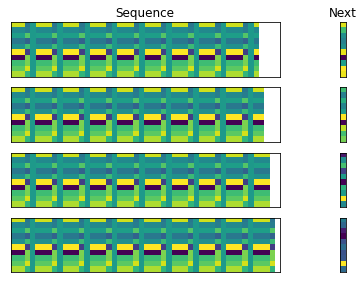

In [304]:
s = [[0,0,0,1]]
N = 100
dictionary2 = np.random.randn(10,input_size)
pairs = unique_pairs(dictionary)
seqc = unique_pairs_sequence(s,10,pairs)
x = [[]]
fig,ax = plt.subplots(len(s[0]),2,figsize=(6.5,4.60), gridspec_kw={'width_ratios': [50, 1]})
j = 1
for i in range(len(s[0])):
    # generate sequence
    
    if i<len(s[0])-1:
        x[0]= torch.Tensor(seqc[0][:,:-len(s[0])+i])
    else:
        x[0]= torch.Tensor(seqc[0][:,:-1])
    y,h = predict(x,model)
    
    ax[i,0].imshow(x[0][j,:,:10].T)
    ax[i,0].set_xlim(0,seqc[0].shape[1]-.5)
    ax[i,1].imshow(y[0][j,None,:10].T)
    ax[i,0].set_xticks([])
    ax[i,1].set_xticks([])
    ax[i,0].set_yticks([])
    ax[i,1].set_yticks([])
    mse = np.mean((y[0][j,:]- seqc[0][j,-len(s[0])+i+1])**2)
    print(mse)
    if i==0:
        ax[i,0].set_title('Sequence')
        ax[i,1].set_title('Next')
#plt.savefig('NIP_example_evaluation2.png')
#plt.savefig('NIP_example_evaluation2.pdf')
plt.show()

## Regression:
find vectors in hidden layer that encode currrent same/different and prediction

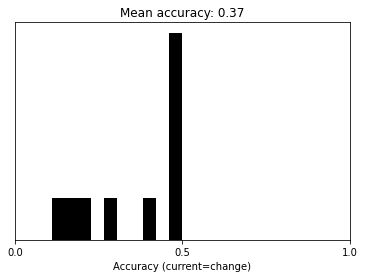

In [245]:
from sklearn.linear_model import LogisticRegression

seqs = [[0,0,0,0],[0,0,0,1]]
pairs = unique_pairs(dictionary)
unique_seq = unique_pairs_sequence(seqs,repeats=10,pairs=pairs)

# to torch
torch_seq = []
for i,s in enumerate(unique_seq):
    torch_seq.append(torch.Tensor(s))
# pass through network

layer = 0 # which layer to use for regression
y,h = predict(torch_seq,model)
Nseq = len(unique_seq)
n_pairs = pairs.shape[0] 
n_stim = dictionary.shape[0]
# leave one out cross validation
score = np.zeros(n_stim)
Coef = np.zeros((n_stim,n_hidden))
for i in range(n_stim):
    testind = np.arange(i*(n_stim-1),(i+1)*(n_stim-1))
    ind = np.delete(np.arange(n_pairs),testind) # remove test indices from training data
    # local deviant items, 
    ################# NOTE: HARD CODED
    Xtest = h[1][layer][testind].detach().numpy()
    Xtrain = h[1][layer][ind].detach().numpy()
    # add local standard sequences at random
    local_std = h[0][layer][ind].detach().numpy()
    Xtrain = np.concatenate((Xtrain,local_std))
    # for test data
    local_std = h[0][layer][testind].detach().numpy()
    Xtest = np.concatenate((Xtest,local_std))
    
    ytrain = np.concatenate((np.ones(len(ind)),np.zeros(len(ind))))
    ytest = np.concatenate((np.ones(len(testind)),np.zeros(len(testind))))

    reg_local = LogisticRegression(solver='lbfgs',max_iter=1000).fit(Xtrain,ytrain)
    yhat_local = reg_local.predict(Xtest)
    score[i] = reg_local.score(Xtest,ytest)
    Coef[i,] = reg_local.coef_
    
plt.hist(score,color='k')
plt.xlim(0,1)
plt.xticks([0,.5,1])
plt.xlabel('Accuracy (current=change)')
plt.yticks([])
plt.title('Mean accuracy: %.2f'%np.mean(score))
plt.savefig('NIP_decoder_current_hist.pdf')
plt.show()# 


## Regression: next stimulus change

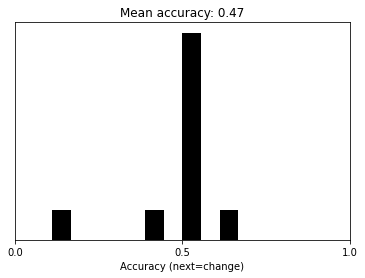

In [246]:
seqs = [[0,0,0,0],[0,0,0,1]]# can't be changed!!
pairs = unique_pairs(dictionary)
unique_seq = unique_pairs_sequence(seqs,repeats=10,pairs=pairs)

# to torch
torch_seq = []
for i,s in enumerate(unique_seq):
    torch_seq.append(torch.Tensor(s[:,:-1,:]))
# pass through network

layer = 0 # which layer to use for regression
y,h = predict(torch_seq,model)
Nseq = len(unique_seq)
n_pairs = pairs.shape[0] 
n_stim = dictionary.shape[0]
# leave one out cross validation
score = np.zeros(n_stim)
Coef = np.zeros((n_stim,n_hidden))
for i in range(n_stim):
    testind = np.arange(i*(n_stim-1),(i+1)*(n_stim-1))
    ind = np.delete(np.arange(n_pairs),testind) # remove test indices from training data
    # local deviant items, 
    ################# NOTE: HARD CODED
    Xtest = h[1][layer][testind].detach().numpy()
    Xtrain = h[1][layer][ind].detach().numpy()
    # add local standard sequences at random
    local_std = h[0][layer][ind].detach().numpy()
    Xtrain = np.concatenate((Xtrain,local_std))
    # for test data
    local_std = h[0][layer][testind].detach().numpy()
    Xtest = np.concatenate((Xtest,local_std))
    
    ytrain = np.concatenate((np.ones(len(ind)),np.zeros(len(ind))))
    ytest = np.concatenate((np.ones(len(testind)),np.zeros(len(testind))))

    reg_local = LogisticRegression(solver='lbfgs',max_iter=1000).fit(Xtrain,ytrain)
    yhat_local = reg_local.predict(Xtest)
    score[i] = reg_local.score(Xtest,ytest)
    Coef[i,] = reg_local.coef_
    
    #ax = plt.subplot(111)
    #ax.imshow(Xtrain.T)
    #ax.set_xticks([])
    #ax.set_yticks([1,100])
    #plt.show()
#
plt.hist(score,color='k')
plt.xlim(0,1)
plt.xticks([0,.5,1])
plt.title('Mean accuracy: %.2f'%np.mean(score))
plt.xlabel('Accuracy (next=change)')
plt.yticks([])
plt.savefig('NIP_decoder_next_hist.pdf')
plt.show()#    


## Multinomial logistic regression for repetition number

[0 1 2 3 4 5 6 7 8]
[ 9 10 11 12 13 14 15 16 17]
[18 19 20 21 22 23 24 25 26]
[27 28 29 30 31 32 33 34 35]
[36 37 38 39 40 41 42 43 44]
[45 46 47 48 49 50 51 52 53]
[54 55 56 57 58 59 60 61 62]
[63 64 65 66 67 68 69 70 71]
[72 73 74 75 76 77 78 79 80]
[81 82 83 84 85 86 87 88 89]
0.2111111111111111


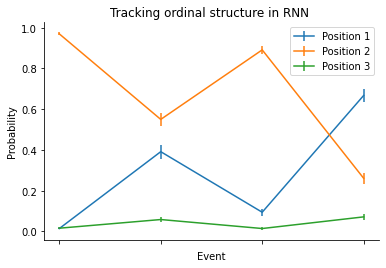

In [263]:
from sklearn.linear_model import LogisticRegression
layer = 0

s = [[0,0,0,1]]
count = [0,1,2,1] # training data needs to be balanced!
test_pc = .2

n_pairs = pairs.shape[0]
######## leave one stimulus out cross-validation
Acc = []
Prob = np.zeros((n_pairs,len(s[0]),max(count)+1))
for k in range(n_stim): # n_pairs
    testind = np.arange(k*(n_stim-1),(k+1)*(n_stim-1)) #k
    
    ind = np.delete(np.arange(n_pairs),testind)
    print(testind)
    Y = []
    X = []
    Ytest = []
    Xtest = []
    # generate sequence
    seq = unique_pairs_sequence(s,10,pairs)
    for i in range(len(s[0])):
        
        if i<len(s[0])-1:
            x[0]= torch.Tensor(seq[0][:,:-len(s[0])+i+1])
        else:
            x[0]= torch.Tensor(seq[0])
        # get network activation
        y,h = predict(x,model)
        Y.extend(count[-len(s[0])+i]*np.ones(len(ind)))
        X.append(h[0][layer][ind,:].detach().numpy())
        Ytest.extend(count[-len(s[0])+i]*np.ones(len(testind)))
        Xtest.append(h[0][layer][testind,:].detach().numpy())
    X = np.concatenate(X)
    Y = np.array(Y)
    Xtest = np.concatenate(Xtest)
    Ytest = np.array(Ytest)


    reg = LogisticRegression(solver='lbfgs',multi_class='auto',max_iter=1000).fit(X,Y)
    acc = reg.score(Xtest,Ytest)
    
    Acc.append(acc)
    
    
    xlabel = []
    string = ['X','Y']
    for i in range(len(s[0])):
        # generate sequence
        if i<len(s[0])-1:
            x[0]= torch.Tensor(seq[0][:,:-len(s[0])+i+1])
        else:
            x[0]= torch.Tensor(seq[0])
        # get network activation
        y,h = predict(x,model)
        
        Prob[testind,i,:] = reg.predict_proba(h[0][layer][testind,:].detach().numpy())
        #xlabel.append(string[s[0][-len(s[0])+i]])
print(np.mean(Acc))

ax = plt.subplot(111)
for i in range(max(count)+1):
    
    ax.errorbar(np.arange(len(s[0])),np.mean(Prob[:,:,i],0),np.std(Prob[:,:,i],0)/np.sqrt(n_pairs),
               label = "Position %s"%(i+1))
#ax.set_ylim(0,1)
ax.set_xticks(np.arange(len(s[0])))
ax.set_xticklabels(xlabel)
plt.xlabel('Event')
plt.title('Tracking ordinal structure in RNN ')
plt.ylabel('Probability')
plt.legend()
ax.spines['top'].set_visible(False)
ax.spines['right'].set_visible(False)
plt.savefig('OrdinalStructure_seq%s.png'%(s[0]))
plt.show()

2